In [1]:
import cv2
import os
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import math
import plotly.graph_objects as go

In [85]:
def showImg(img: cv2.typing.MatLike):
    plt.imshow(img, cmap='gray')
    plt.axis('off')  # Hide axes
    plt.show()

def plot3D(data):
    z, x, y = np.indices(data.shape)
    values = data.flatten()
    
    # Normalize values to range [0, 1] for opacity
    normalized_values = (values - values.min()) / (values.max() - values.min())
    
    # Create RGBA colors with opacity based on normalized values
    colors = [f'rgba(0, 0, 255, {opacity})' for opacity in normalized_values]

    # Create the 3D scatter plot
    fig = go.Figure(data=[go.Scatter3d(
        x=x.flatten(),
        y=y.flatten(),
        z=z.flatten(),
        mode='markers',
        marker=dict(
            size=5,
            color=colors,
            colorscale='Viridis',
            colorbar=dict(title='Value')
        )
    )])

    # Update layout for better visibility
    fig.update_layout(scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Rad'
    ),
        width=800,
        height=800,
        title='Accumulator greatest values'
    )

    # Display the plot
    fig.show()

In [3]:
def get_edges(img: cv2.typing.MatLike, ksize=1):
    #calculating the derivatives/sobels on both axis
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=ksize)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=ksize)
    
    #combining both axis sobels
    sobel = np.hypot(sobel_x, sobel_y)

    
    sobel = np.divide(sobel, sobel.max(), out=sobel)
    sobel = np.multiply(sobel, 255, out=sobel)
    
    #conversion to array of uint8 to free up space
    edges: np.ndarray[np.unit8] = np.uint8(sobel)

    return edges

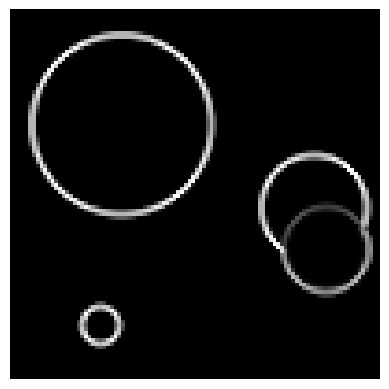

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
def detect_circles(path: str,
                   rad_min: int, rad_max: int, rad_step: int,
                   x_min: int, x_max: int, x_step: int,
                   y_min: int, y_max: int, y_step: int,
                   ksize: int=1):
    
    

    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    img_width, img_height = img.shape[0], img.shape[1]

    wrongBounds = False
    wrongBounds = x_min < 0 or x_max > img_width or y_min < 0 or y_max > img_height or rad_min < 0
    
    if (wrongBounds):
        print("Error : Wrong dimensions")
        return

    #getting the image containing the edges
    edges_img = get_edges(img, ksize=ksize)
    showImg(edges_img)
    #iterating through the edges pixels
    threshold = 100     #minimum value for a pixel of edges_img to be considered as part of an edge
    
    #creating the accumulator
    acc_x_max = (x_max-x_min)//x_step
    acc_y_max = (y_max-y_min)//y_step
    acc_rad_max = (rad_max - rad_min) // rad_step
    
    acc = np.zeros((acc_rad_max, acc_x_max, acc_y_max))

    
    for rad in range(rad_min, rad_max, rad_step):
        for x in range(x_min, x_max, x_step):
            for y in range(y_min, y_max, y_step):
                if (edges_img[x][y] > threshold):
                    
                    #change of variable : this part of the code probably has a mistake
                    X = (x-x_min)//x_step
                    Y = (y-y_min)//y_step
                    RAD = (rad-rad_min)//rad_step
                    if RAD >= acc_rad_max:
                        continue
                    

                    #FILLING THE ACCUMULATOR
                    ang_step = 1/rad  #pretty much random I just found this value works well

                    for ang in np.arange(0, 2*math.pi, ang_step):   #drawing the circle
                        vote_x = math.floor(X+ (rad*math.cos(ang))//x_step)
                        if vote_x < 0 or vote_x >= acc_x_max:
                            continue
                        vote_y = math.floor(Y+ (rad*math.sin(ang))//y_step)
                        if vote_y < 0 or vote_y >= acc_y_max:
                            continue
                            
                        acc[RAD][vote_x][vote_y] += 1
    
        #Egaliser les votes en fonction du radp
        #print("---------------", acc[RAD][20][20])
        acc[RAD] = acc[RAD]/(rad*math.pi)
        #print("---------------", acc[RAD][20][20])


    #Searching for local maximas of votes (most voted cells) aka the coordinates of the circles.
    res = []
    max = 0
    for rad in range(acc.shape[0]):
        for x in range(acc.shape[1]):
            for y in range(acc.shape[2]):
                val = acc[rad-1:rad+1, rad-1:rad+1, rad-1:rad+1].max()
                if val > 0.9:
                    res.append((rad, x, y))


                """for RAD in range(rad-1, rad+2):
                    for X in range(x-1, x+2):
                        for Y in range(y-1, y+2):
                            try:
                                max = max(acc[RAD][X][Y], max)
                            except:
                                continue"""
    print("LE RESULTAT ; ", res)
    return acc


#checking that the normalization works as intended
"""acc = detect_circles('images/25-25grand.png',
               10, 50, 1,
               0, 50, 1,
               0, 50, 1,
               ksize=1)

showImg(acc[12])
for radius in range(acc.shape[0]):
    print(acc[radius][25][25])


acc = detect_circles('images/25-25moyen.png',
               10, 50, 1,
               0, 50, 1,
               0, 50, 1,
               ksize=1)

showImg(acc[12])
for radius in range(acc.shape[0]):
    print(acc[radius][25][25])"""


acc = detect_circles('images/four.png',
               10, 50, 1,
               0, 100, 2,
               0, 100, 2,
               ksize=1)

#showImg(acc[2])

"""acc2 = acc
for x in range(acc2.shape[0]):
    for y in range(acc2.shape[1]):
        for z in range(acc2.shape[2]):
            if acc2[x][y][z] < 0.5:
                acc2[x][y][z] = 0
plot3D(acc2)"""

In [108]:
acc[0:3, 0:3].shape

(3, 3, 50)

[255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255]


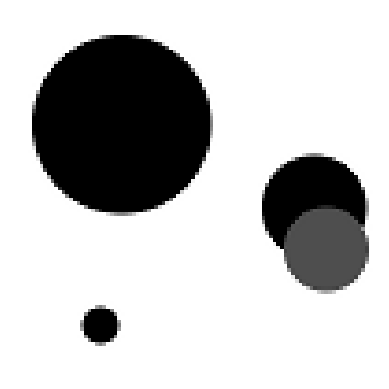

In [5]:
img = cv2.imread('images/four.png', cv2.IMREAD_GRAYSCALE)

print(img[0])
showImg(img)

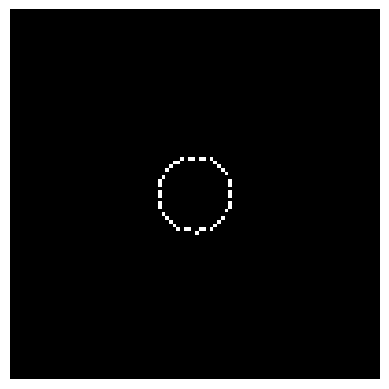

In [6]:
def fillAcc(x, y, rad):
    acc_x_max = 100
    acc_y_max = 100
    acc_rad_max = 100

    acc = np.zeros((acc_rad_max, acc_x_max, acc_y_max))
    
    ang_step = 1.5/rad  #pretty much random I just found this value works well

    for ang in np.arange(0, 2*math.pi, ang_step):
        vote_x = math.floor(x+rad*math.cos(ang))
        if vote_x < 0 or vote_x >= acc_x_max:
            continue
        vote_y = math.floor(y+rad*math.sin(ang))
        if vote_y < 0 or vote_y >= acc_y_max:
            continue

        acc[rad][vote_x][vote_y] += 1
    showImg(acc[rad])

fillAcc(50, 50, 10)